# Notebook for calculating and plotting potential vorticity

**Mar 31, 2022**

Potential vorticity (PV) is an important quantity especially in synoptic meteorology, however, it is not included in the Aus400 catalogue and must be calculated manually. This notebook goes through the PV calculation, giving options for height/pressure/isentropic coordinates.

In height coordinates the (Ertel) PV is given by:

$P= \frac{(f + \nabla \times \mathbf{u}) \cdot \nabla\theta}{\rho}$

where $f$ is the planetary vorticity/Coriolis parameter, $\mathbf{u}$ is the full 3D wind, $\theta$ is potential temperature and $\rho$ is density.

We also calculate *equivalent potential vorticity* (EPV), where potential temperature $\theta$ is replaced by equivalent potential temperature $\theta_e$ in the formula above. The formula for $\theta_e$ is based off Bolton (1980) -- see derived_vars.py for more details.

This can be a very expensive computation, especially with the need to interpolate large amounts of data to height/etc. coordinates. It may be useful to calculate PV on model levels instead, which should be similar to PV on absolute height coordindates, except near the surface in elevated regions. This reduces the computation time since we don't need to operate on all model levels -- just the one we're interested in.

*Note: vertical interpolation to pressure or height levels doesn't seem to work when using CLEX's conda environment analysis3-21.10 or above. There appears to be an incompatibility between xgcm and xarray versions. Using analysis3-21.07 works as intended.*

## Setup

In [1]:
# import aus400 module
import sys
sys.path.append('Documents/aus400/aus400-cookbook/')
import aus400

# other modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, LocalCluster, Scheduler
import pandas as pd

# # code containing calculations for PV
# sys.path.append('Documents/aus400/aus400-cookbook/notebooks')
# from calculations import *

**Setup a dask cluster:**

Because this is an intense computation, it is generally useful to use the higher power/memory of the SLURM cluster.

In [2]:
# try:
#     client
# except:
#     cluster = LocalCluster()
#     client = Client(cluster)

from dask_jobqueue import SLURMCluster
try:
    client
except:
    cluster = SLURMCluster(cores=16,memory="31GB")
    client = Client(cluster)
    cluster.scale(cores=32)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39979 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/39979/status,
Dashboard: /proxy/39979/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.160:43487,Workers: 0
Dashboard: /proxy/39979/status,Total threads: 0
Started: Just now,Total memory: 0 B


**Data options:**

In [4]:
res = 'd0198'                  # resolution: 'd0198' or 'd0036'
time = '2017-03-28T13:00'      # time to plot

# region to plot
[[min_lon, max_lon], [min_lat, max_lat]] = [[142, 150], [-23, -15]]

# what kind of level to plot the data on: 
# - 'model' for model level
# - 'p' for pressure level
# - 'z' for height level
# - 'theta' for potential temperature level
vert = 'model'

plevs = np.arange(25, 1025, 25) * 1e2   # pressure levels to calculate PV on (if level == 'p')
thetalevs = np.arange(275, 405, 5)      # theta levels to calculate PV on (if level == 'theta')
zlevs = np.arange(0, 15000, 150)        # height levels to calculate PV on (of level == 'z')

pressure_plot = 850e2    # pressure level to plot (if level == 'p')
height_plot = 1000       # height level to plot (if level == 'z')
theta_plot = 330         # theta level to plot (if level == 'theta')
mlev = 10                # model level to plot (if level == 'model')

# minimum/maximum PV values in the plots (in PVU)
vmin, vmax = -1e-5, 1e-5

## Load and subset the data

Here `load_time` is altered from `time` to ensure that the correct time is loaded (otherwise the data will be typically be 1 hour too late)

In [5]:
load_time = pd.Timestamp(time)
if load_time.minute != 0:
    load_time = load_time - pd.Timedelta(load_time.minute, 'm')
else:
    load_time = pd.Timestamp(time) - pd.Timedelta(1, 'h')
if load_time.hour % 6 != 0 and res == 'd0198':
    # Times for d0198 dataset are weird -- if they are not every 6 hours you need to add 1 minute. 
    # e.g. 05:01 and 06:00
    load_time = load_time + pd.Timedelta(1, 'm')

wnd_ucmp = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='wnd_ucmp', time=load_time)
wnd_vcmp = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='wnd_vcmp', time=load_time)
vert_wnd = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='vertical_wnd', time=load_time)
air_temp = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='air_temp', time=load_time)
pressure = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='pressure', time=load_time)
spec_hum = aus400.cat.load_var(ensemble=0, resolution=res, stream='mdl', variable='spec_hum', time=load_time)

# cut off relevant domain
wnd_ucmp = wnd_ucmp.sel({'latitude': slice(min_lat, max_lat), 'longitude': slice(min_lon, max_lon)})
wnd_vcmp = wnd_vcmp.sel({'latitude': slice(min_lat, max_lat), 'longitude': slice(min_lon, max_lon)})
vert_wnd = vert_wnd.sel({'latitude': slice(min_lat, max_lat), 'longitude': slice(min_lon, max_lon)})
air_temp = air_temp.sel({'latitude': slice(min_lat, max_lat), 'longitude': slice(min_lon, max_lon)})
pressure = pressure.sel({'latitude': slice(min_lat, max_lat), 'longitude': slice(min_lon, max_lon)})
spec_hum = spec_hum.sel({'latitude': slice(min_lat, max_lat), 'longitude': slice(min_lon, max_lon)})

**Regrid u/v to the scalar grid:**



In [6]:
wnd_ucmp = aus400.regrid.regrid_vector(wnd_ucmp)
wnd_vcmp = aus400.regrid.regrid_vector(wnd_vcmp)

# ensure all data has the same size and coorindates (u/v are sometimes on a slightly different grid, even after regridding)
wnd_ucmp = wnd_ucmp.reindex_like(air_temp, method='nearest')
wnd_vcmp = wnd_vcmp.reindex_like(air_temp, method='nearest')

**Select model levels or interpolate to height/pressure/theta levels:**

In [7]:
if vert == 'model':
    
    # change vertical coordinate from model level number to model level height
    # also rechunk so that there is only 1 chunk in the vertical (for vertical derivatives)
    wnd_ucmp = wnd_ucmp.swap_dims({'model_level_number': 'level_height'}).chunk({'level_height': -1}).squeeze()
    wnd_vcmp = wnd_vcmp.swap_dims({'model_level_number': 'level_height'}).chunk({'level_height': -1}).squeeze()
    vert_wnd = vert_wnd.swap_dims({'model_level_number': 'level_height'}).chunk({'level_height': -1}).squeeze()
    air_temp = air_temp.swap_dims({'model_level_number': 'level_height'}).chunk({'level_height': -1}).squeeze()
    pressure = pressure.swap_dims({'model_level_number': 'level_height'}).chunk({'level_height': -1}).squeeze()
    spec_hum = spec_hum.swap_dims({'model_level_number': 'level_height'}).chunk({'level_height': -1}).squeeze()
    
    # model levels require 3 levels for central difference derivatives
    wnd_ucmp = wnd_ucmp.isel(level_height=slice(mlev-1,mlev+2))
    wnd_vcmp = wnd_vcmp.isel(level_height=slice(mlev-1,mlev+2))
    vert_wnd = vert_wnd.isel(level_height=slice(mlev-1,mlev+2))
    air_temp = air_temp.isel(level_height=slice(mlev-1,mlev+2))
    pressure = pressure.isel(level_height=slice(mlev-1,mlev+2))
    spec_hum = spec_hum.isel(level_height=slice(mlev-1,mlev+2))
    
    # u/v have slightly different model level heights -- for simplicity, let's just align them
    wnd_ucmp = wnd_ucmp.reindex_like(air_temp, method='pad')
    wnd_vcmp = wnd_vcmp.reindex_like(air_temp, method='pad')
    
elif vert == 'z':
    wnd_ucmp = aus400.vertical.to_height(wnd_ucmp, zlevs)
    wnd_vcmp = aus400.vertical.to_height(wnd_vcmp, zlevs)
    vert_wnd = aus400.vertical.to_height(vert_wnd, zlevs)
    air_temp = aus400.vertical.to_height(air_temp, zlevs)
    pressure = aus400.vertical.to_height(pressure, zlevs)
    spec_hum = aus400.vertical.to_height(spec_hum, zlevs)
elif vert == 'p':
    wnd_ucmp = aus400.vertical.to_plev(wnd_ucmp, plevs).squeeze()
    wnd_vcmp = aus400.vertical.to_plev(wnd_vcmp, plevs).squeeze()
    vert_wnd = aus400.vertical.to_plev(vert_wnd, plevs).squeeze()
    air_temp = aus400.vertical.to_plev(air_temp, plevs).squeeze()
    pressure = aus400.vertical.to_plev(pressure, plevs).squeeze()
    spec_hum = aus400.vertical.to_plev(spec_hum, plevs).squeeze()
elif vert == 'theta':
    wnd_ucmp = aus400.vertical.to_isentropic(wnd_ucmp, thetalevs).squeeze()
    wnd_vcmp = aus400.vertical.to_isentropic(wnd_vcmp, thetalevs).squeeze()
    vert_wnd = aus400.vertical.to_isentropic(vert_wnd, thetalevs).squeeze()
    air_temp = aus400.vertical.to_isentropic(air_temp, thetalevs).squeeze()
    pressure = aus400.vertical.to_isentropic(pressure, thetalevs).squeeze()
    spec_hum = aus400.vertical.to_isentropic(spec_hum, thetalevs).squeeze()

**Rechunk the data**

The larger chunks seem to improve performance in the following calculations.

In [8]:
wnd_ucmp = wnd_ucmp.chunk({'latitude': 500, 'longitude': 500})
wnd_vcmp = wnd_vcmp.chunk({'latitude': 500, 'longitude': 500})
vert_wnd = vert_wnd.chunk({'latitude': 500, 'longitude': 500})
air_temp = air_temp.chunk({'latitude': 500, 'longitude': 500})
pressure = pressure.chunk({'latitude': 500, 'longitude': 500})
spec_hum = spec_hum.chunk({'latitude': 500, 'longitude': 500})

**Calculate PV/EPV:**

See `aus400.calc` for more details

In [9]:
%%time
PV = aus400.calc.pot_vort(wnd_ucmp, wnd_vcmp, vert_wnd, air_temp, pressure, spec_hum)
EPV = aus400.calc.equiv_pot_vort(wnd_ucmp, wnd_vcmp, vert_wnd, air_temp, pressure, spec_hum)

PV = PV.compute()
EPV = EPV.compute()

PV

CPU times: user 24.9 s, sys: 1.8 s, total: 26.7 s
Wall time: 45.7 s


<xarray.DataArray (level_height: 3, latitude: 404, longitude: 404)>
array([[[ 1.22402531e-07,  9.55169309e-08,  3.92306185e-08, ...,
         -3.16600163e-07, -3.50137814e-07, -2.64027691e-07],
        [ 1.14054432e-07,  7.84801597e-08,  2.12012492e-08, ...,
         -3.30703663e-07, -4.03165708e-07, -2.85170935e-07],
        [ 1.09814487e-07,  6.41734188e-08,  7.30691617e-09, ...,
         -2.34333001e-07, -4.44507489e-07, -5.21863041e-07],
        ...,
        [-5.15134487e-08, -5.15444325e-08, -2.97891457e-08, ...,
          6.73009628e-08,  7.72903259e-08,  1.21864314e-07],
        [-2.80159351e-08, -2.82635490e-08, -2.27328388e-08, ...,
          7.30180433e-08,  9.52442525e-08,  1.74333826e-07],
        [-4.29094004e-08, -3.93212920e-08, -3.21628481e-08, ...,
          1.09982618e-07,  1.43881555e-07,  1.91637336e-07]],

       [[ 1.09719286e-07,  5.03063507e-08, -6.28338321e-08, ...,
         -2.66098677e-07, -2.92930903e-07, -2.23506249e-07],
        [ 7.78150232e-08,  1.54638977e-08, -7.48097335e-08, ...,
         -3.10630132e-07, -3.78266409e-07, -2.65526319e-07],
        [ 4.23729125e-08, -2.16751323e-08, -9.15943993e-08, ...,
         -1.65384691e-07, -3.23679169e-07, -4.05173447e-07],
...
        [-1.88976481e-07, -1.74976475e-07, -1.06446402e-07, ...,
          8.16229602e-08,  1.00329840e-07,  1.49405904e-07],
        [-1.23478193e-07, -1.23064956e-07, -1.02457128e-07, ...,
          6.84706701e-08,  1.05431975e-07,  1.56527632e-07],
        [-1.45097206e-07, -1.39292841e-07, -1.20543275e-07, ...,
          9.90630597e-08,  1.50852327e-07,  1.59275152e-07]],

       [[ 7.37563401e-08, -1.44745697e-08, -1.68484664e-07, ...,
         -2.34041875e-07, -2.03355513e-07, -1.65073667e-07],
        [-1.76098124e-08, -8.96017028e-08, -1.74132297e-07, ...,
         -3.60922541e-07, -3.83163779e-07, -3.37681144e-07],
        [-1.33387337e-07, -1.94531409e-07, -2.32362752e-07, ...,
         -2.35562837e-07, -3.45643578e-07, -4.92434125e-07],
        ...,
        [-3.23443773e-07, -2.20103212e-07, -3.57960074e-08, ...,
          6.46884759e-08,  8.19396552e-08,  1.23179036e-07],
        [-2.08726688e-07, -1.40333403e-07, -5.65470099e-08, ...,
          2.17170940e-08,  8.64650027e-08,  1.38465478e-07],
        [-1.99102751e-07, -1.30504266e-07, -6.71105102e-08, ...,
          2.98382791e-08,  1.41031455e-07,  1.78502627e-07]]])
Coordinates:
    time                     datetime64[ns] 2017-03-28T13:00:00
    model_level_number       (level_height) int32 10 11 12
  * latitude                 (latitude) float32 -22.99 -22.97 ... -15.03 -15.01
  * longitude                (longitude) float32 142.0 142.0 ... 150.0 150.0
    forecast_period          timedelta64[ns] 07:00:00
    forecast_reference_time  datetime64[ns] 2017-03-28T06:00:00
  * level_height             (level_height) float64 371.4 447.9 531.4
    sigma                    (level_height) float64 0.9579 0.9494 0.9401
    ensemble                 int64 0

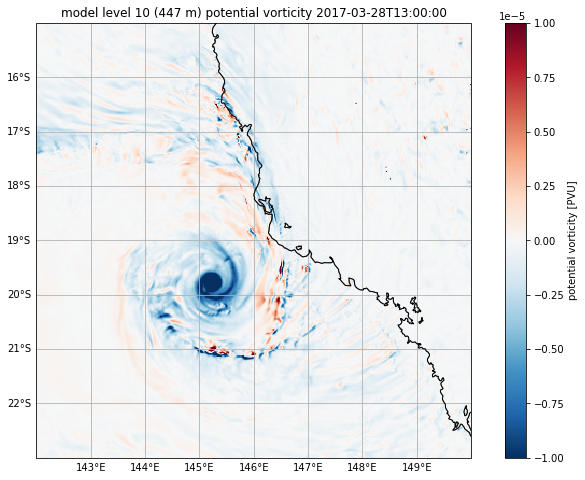

In [10]:
[lats, lons] = np.meshgrid(PV.latitude, PV.longitude, indexing='ij')
time_format = str(PV.time.values.squeeze())[:19]

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=3)
ax.add_feature(cfeature.STATES, edgecolor='gray', zorder=2)
ax.set_extent((min_lon, max_lon, min_lat, max_lat), crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

if vert == 'model':
    level_height = int(PV.isel(level_height=1).level_height)
    cf = ax.pcolormesh(lons, lats, PV.isel(level_height=1).squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'model level {mlev} ({level_height} m) potential vorticity {time_format}')
elif vert == 'z':
    cf = ax.pcolormesh(lons, lats, PV.sel(height_rho=height_plot, method='nearest').squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'{height_plot} m potential vorticity {time_format}')
elif vert == 'p':
    cf = ax.pcolormesh(lons, lats, PV.sel(pressure=pressure_plot, method='nearest').squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'{int(pressure_plot/100)} hPa potential vorticity {time_format}')
elif vert == 'theta':
    cf = ax.pcolormesh(lons, lats, PV.sel(theta=theta_plot, method='nearest').squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'{theta_plot} K potential vorticity {time_format}')

cb = plt.colorbar(cf, label='potential vorticity [PVU]')

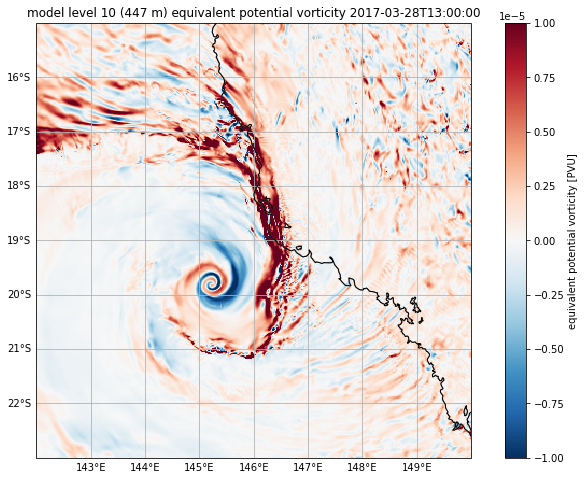

In [11]:
[lats, lons] = np.meshgrid(EPV.latitude, EPV.longitude, indexing='ij')
time_format = str(EPV.time.values.squeeze())[:19]

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(zorder=3)
ax.add_feature(cfeature.STATES, edgecolor='gray', zorder=2)
ax.set_extent((min_lon, max_lon, min_lat, max_lat), crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

if vert == 'model':
    level_height = int(EPV.isel(level_height=1).level_height)
    cf = ax.pcolormesh(lons, lats, EPV.isel(level_height=1).squeeze(), vmin=vmin, vmax=10e-6, cmap='RdBu_r')
    plt.title(f'model level {mlev} ({level_height} m) equivalent potential vorticity {time_format}')
elif vert == 'z':
    cf = ax.pcolormesh(lons, lats, EPV.sel(height_rho=height_plot, method='nearest').squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'{height_plot} m equivalent potential vorticity {time_format}')
elif vert == 'p':
    cf = ax.pcolormesh(lons, lats, EPV.sel(pressure=pressure_plot, method='nearest').squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'{int(pressure_plot/100)} hPa equivalent potential vorticity {time_format}')
elif vert == 'theta':
    cf = ax.pcolormesh(lons, lats, EPV.sel(theta=theta_plot, method='nearest').squeeze(), vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(f'{theta_plot} K equivalent potential vorticity {time_format}')

cb = plt.colorbar(cf, label='equivalent potential vorticity [PVU]')

**Saving the output data:**

Note: because PV can take a while to calculate, it may be useful to save the result on disk somewhere, then load and analyse in a separate notebook or program. 

In [12]:
# # add variable names to the data
# PV = PV.rename('pv')
# EPV = EPV.rename('epv')

In [13]:
# %%time
# # save the data in home directory (change to suit your needs)
# comp = dict(zlib=True, complevel=5)
# path = '~/Documents/aus400/pv_data/'

# PV.to_netcdf(path+'pv.nc', encoding={'pv': comp})
# EPV.to_netcdf(path+'epv.nc', encoding={'epv': comp})